In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install pytorch_pretrained_bert pytorch-nlp -q
!pip install transformers

## 1.Importing Libraries

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification, BertAdam
#from transformers import BertTokenizer, BertForSequenceClassification #, BertAdam
from transformers import BertConfig,BertModel,AdamW,get_linear_schedule_with_warmup, BertForSequenceClassification

import torch
from torch.nn import BCEWithLogitsLoss, Sigmoid
import torch.nn as nn

from tqdm.notebook import tqdm, trange # # trange(i) is equal to tqdm(range(i))

from sklearn.model_selection import train_test_split

# 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 2.Reading Dataset

In [224]:
df_train = pd.read_csv("/content/drive/MyDrive/Data mining and Text Analytics/group work/jigsaw-toxic-comment-classification-challenge/train.csv.zip")
#df_test = pd.read_csv("/content/drive/MyDrive/Data mining and Text Analytics/group work/jigsaw-toxic-comment-classification-challenge/test.csv.zip")
df_test = pd.read_csv("/content/drive/MyDrive/Data mining and Text Analytics/group work/jigsaw-toxic-comment-classification-challenge/Reddit_final.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/Data mining and Text Analytics/group work/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip")

print(df_train.shape, df_test.shape, sample_submission.shape)
# (159571, 8) (153164, 2) (153164, 7)
df_train.head()

(159571, 8) (14291, 2) (153164, 7)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## 3.Data exploration

### 3.1 check the data

In [5]:
print(df_train.shape, df_test.shape, sample_submission.shape)
# (159571, 8) (153164, 2) (153164, 7)
df_train[10:20] # or train_df.sample(5)

(159571, 8) (153164, 2) (153164, 7)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
10,0005300084f90edc,"""\nFair use rationale for Image:Wonju.jpg\n\nT...",0,0,0,0,0,0
11,00054a5e18b50dd4,bbq \n\nbe a man and lets discuss it-maybe ove...,0,0,0,0,0,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
13,0006f16e4e9f292e,Before you start throwing accusations and warn...,0,0,0,0,0,0
14,00070ef96486d6f9,"Oh, and the girl above started her arguments w...",0,0,0,0,0,0
15,00078f8ce7eb276d,"""\n\nJuelz Santanas Age\n\nIn 2002, Juelz Sant...",0,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
17,000897889268bc93,REDIRECT Talk:Voydan Pop Georgiev- Chernodrinski,0,0,0,0,0,0
18,0009801bd85e5806,The Mitsurugi point made no sense - why not ar...,0,0,0,0,0,0
19,0009eaea3325de8c,Don't mean to bother you \n\nI see that you're...,0,0,0,0,0,0


In [96]:
df_test.head()

,comment_text,id
0,serious suggestions only 😆,u9cg12
1,cool recovery at practice 1,u9di1r
2,Which song's lyrics sounds innocent but actual...,u8ybww
3,Boomer owner send this out last night before l...,u9eh2r
4,This sign at an Illinois rest stop encouraging...,u93285


In the training data, the comments are labelled as one or more of the six categories; toxic, severe toxic, obscene, threat, insult and identity hate. This is essentially a multi-label classification problem.

In [7]:
cols_target = df_train.columns[2:]
cols_target = cols_target.tolist()
cols_target

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

### 3.2 check the null values

check missing values in 'Comments' and 'Labels'

All rows in the training and test data contain comments, so there's no need to clean up null fields.

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [126]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14119 entries, 0 to 14118
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  14119 non-null  object
 1   id            14119 non-null  object
dtypes: object(2)
memory usage: 220.7+ KB


### 3.3 check the number of different types of comment

As the mean values are very small (some way below 0.05), there would be many not labelled as positive in the six categories. 

In [10]:
df_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


There would be many comments which are not labelled in any of the six categories, which is around 89.83

In [11]:
unlabelled_in_all = df_train[(df_train['toxic']!=1) & (df_train['severe_toxic']!=1) & (df_train['obscene']!=1) & 
                            (df_train['threat']!=1) & (df_train['insult']!=1) & (df_train['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(df_train)*100)

Percentage of unlabelled comments is  89.83211235124176


let's see the total rows in train, test data and the numbers for the various categories

In [12]:
# cate_nums = df_train[cols_target].sum()
# cate_nums

In [13]:
clean_comment = df_train[(df_train['toxic']!=1) & (df_train['severe_toxic']!=1) & (df_train['obscene']!=1) & (df_train['threat']!=1) & (df_train['insult']!=1) & (df_train['identity_hate']!=1)]['comment_text']

toxic = df_train[(df_train['toxic']==1)]['comment_text']
severe_toxic = df_train[(df_train['severe_toxic']==1)]['comment_text']
obscene = df_train[(df_train['obscene']==1)]['comment_text']
threat = df_train[(df_train['threat']==1)]['comment_text']
insult = df_train[(df_train['insult']==1)]['comment_text']
identity_hate = df_train[(df_train['identity_hate']==1)]['comment_text']

print('the number of each type of comment: ')
print('clean comment: ',len(clean_comment))

print('toxic comment: ',len(toxic))
print('severe toxic comment: ',len(severe_toxic))
print('obscene comment: ',len(obscene))
print('threat comment: ',len(threat))
print('insult comment: ',len(insult))
print('identity hate comment: ',len(identity_hate))

the number of each type of comment: 
clean comment:  143346
toxic comment:  15294
severe toxic comment:  1595
obscene comment:  8449
threat comment:  478
insult comment:  7877
identity hate comment:  1405


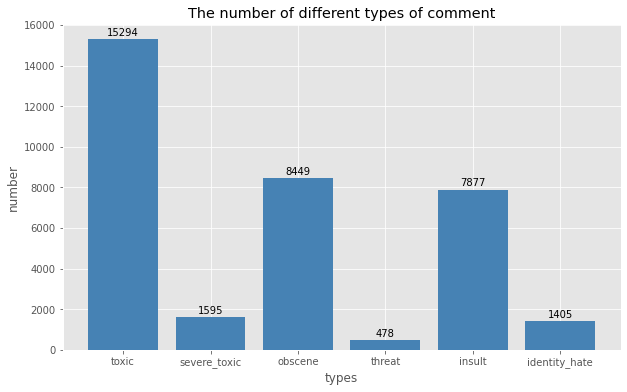

In [14]:
# using different style to draw table
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
left = range(len(cols_target))
value_list = [len(toxic), len(severe_toxic), len(obscene), len(threat), len(insult), len(identity_hate)]
tick_label = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
plt.bar(x=left, height=value_list, tick_label=tick_label, color='steelblue')
plt.title('The number of different types of comment')
plt.ylabel('number')
plt.xlabel('types')

for x, y in enumerate(value_list):
  plt.text(x, y+200, '%s'%round(y,1), ha='center')
plt.show()

In [15]:
# adjust the distance between 'toxic' and title
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 

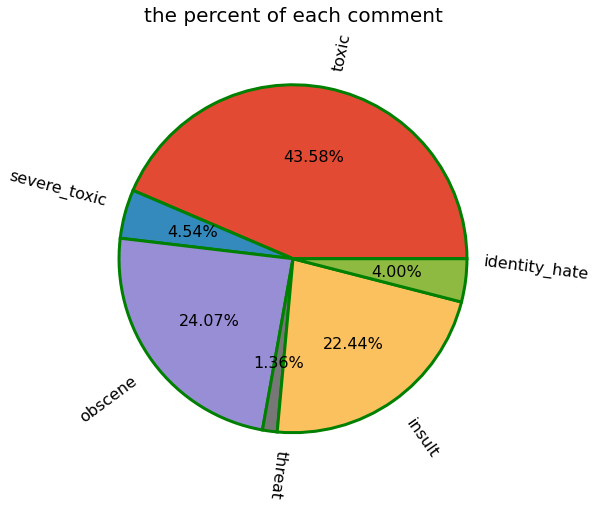

In [16]:
names = tick_label
percents = value_list
plt.figure(figsize=(12,8))
plt.title('the percent of each comment', fontsize=20)
patches,texts,autotexts = plt.pie(percents, labels=names, autopct="%.2f%%", textprops={'fontsize':16}, wedgeprops = {'linewidth': 3, 'edgecolor':'g'}, center=(0.2,0.2), rotatelabels=True)

### 3.4 check the length of comments

(1) train dataset

Let's look at the character length for the rows in the training data and record these

In [17]:
df_train['char_length'] = df_train['comment_text'].apply(lambda x: len(str(x)))

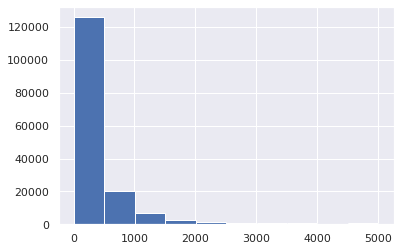

In [18]:
# look at the histogram plot for text length
sns.set()
df_train['char_length'].hist()
plt.show()

Most of the text length are within 500 characters, with some up to 5,000 characters long.

(2) test dataset

In [19]:
df_test['char_length'] = df_test['comment_text'].apply(lambda x: len(str(x)))

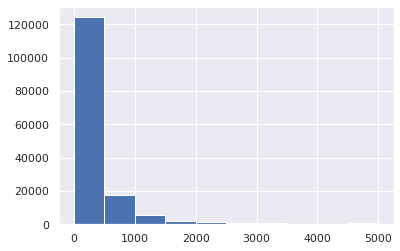

In [20]:
plt.figure()
plt.hist(df_test['char_length'])
plt.show()

Now, the shape of character length distribution looks similar between the training data and the train data.



drop columns which are not belong to original dataset

In [21]:
df_train.drop('char_length',axis=1,inplace=True)
df_test.drop('char_length',axis=1,inplace=True)

### 3.5 Correlations among the target variables.

In [22]:
data = df_train[cols_target]

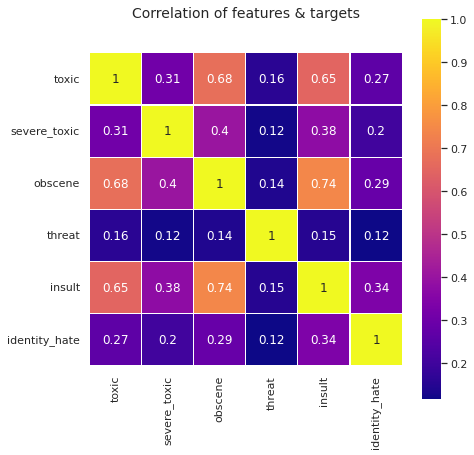

In [23]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

Indeed, it looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene and toxic-insult.

### 3.6 exploring the frequent words (wordcloud)

import related library

In [24]:
from wordcloud import WordCloud,STOPWORDS

clean text

In [25]:
import re
def text_preprocessing(text):
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r'[0-9]+' , '' ,text)
    text = re.sub(r'\s([@][\w_-]+)', '', text).strip()
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.replace("#" , " ")
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

0 cleaned, 1 toxic, 2 severe_toxic, 3 obscene, 4 threat, 5 insult, 6 identity_hate

In [26]:
clean_comment = clean_comment

toxic = df_train[df_train['toxic']==1]['comment_text']
severe_toxic = df_train[df_train['severe_toxic']==1]['comment_text']
obscene = df_train[df_train['obscene']==1]['comment_text']
threat = df_train[df_train['threat']==1]['comment_text']
insult = df_train[df_train['insult']==1]['comment_text']
identity_hate = df_train[df_train['identity_hate']==1]['comment_text']

In [27]:
X0 = []
for items in clean_comment:
    X0.append(text_preprocessing(items))
X1 = []
for items in toxic:
    X1.append(text_preprocessing(items))
X2 = []
for items in severe_toxic:
    X2.append(text_preprocessing(items))
X3 = []
for items in obscene:
    X3.append(text_preprocessing(items))
X4 = []
for items in threat:
    X4.append(text_preprocessing(items))
X5 = []
for items in insult:
    X5.append(text_preprocessing(items))
X6 = []
for items in identity_hate:
    X6.append(text_preprocessing(items))

In [28]:
# 0 cleaned, 
commonWord0 = ' '.join(X0)
# 1 toxic
commonWord1 = ' '.join(X1)
# 2 severe_toxic
commonWord2 = ' '.join(X2)
# 3 obscene
commonWord3 = ' '.join(X3)
# 4 threat
commonWord4 = ' '.join(X4)
# 5 insult
commonWord5 = ' '.join(X5)
# 6 identity_hate
commonWord6 = ' '.join(X6)

(0) clean comment

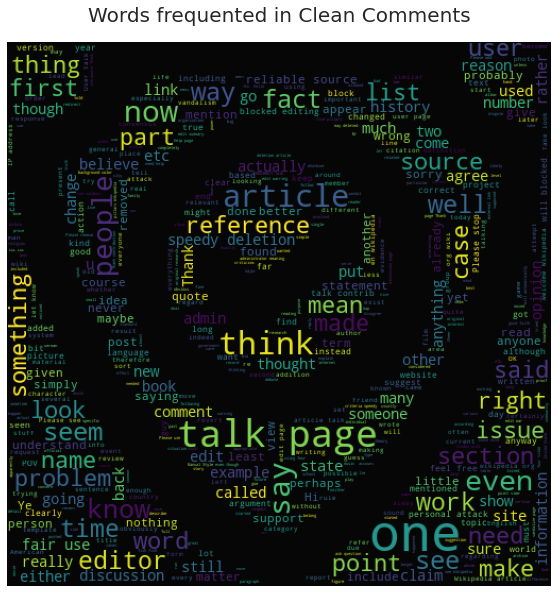

In [29]:
clean_mask=np.array(Image.open('/content/drive/MyDrive/Data mining and Text Analytics/group work/picture/safe-zone.png'))
clean_mask=clean_mask[:,:,1]

text = commonWord0
wc = WordCloud(background_color='black', max_words=2000, mask=clean_mask,stopwords=STOPWORDS) #  width=3000,height=2500
wc.generate(text)
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title('Words frequented in Clean Comments', fontsize=20)
plt.imshow(wc.recolor(colormap='viridis', random_state=17), alpha=0.98)
plt.show()

(1) rest six types of comment

[colormaps](https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html)

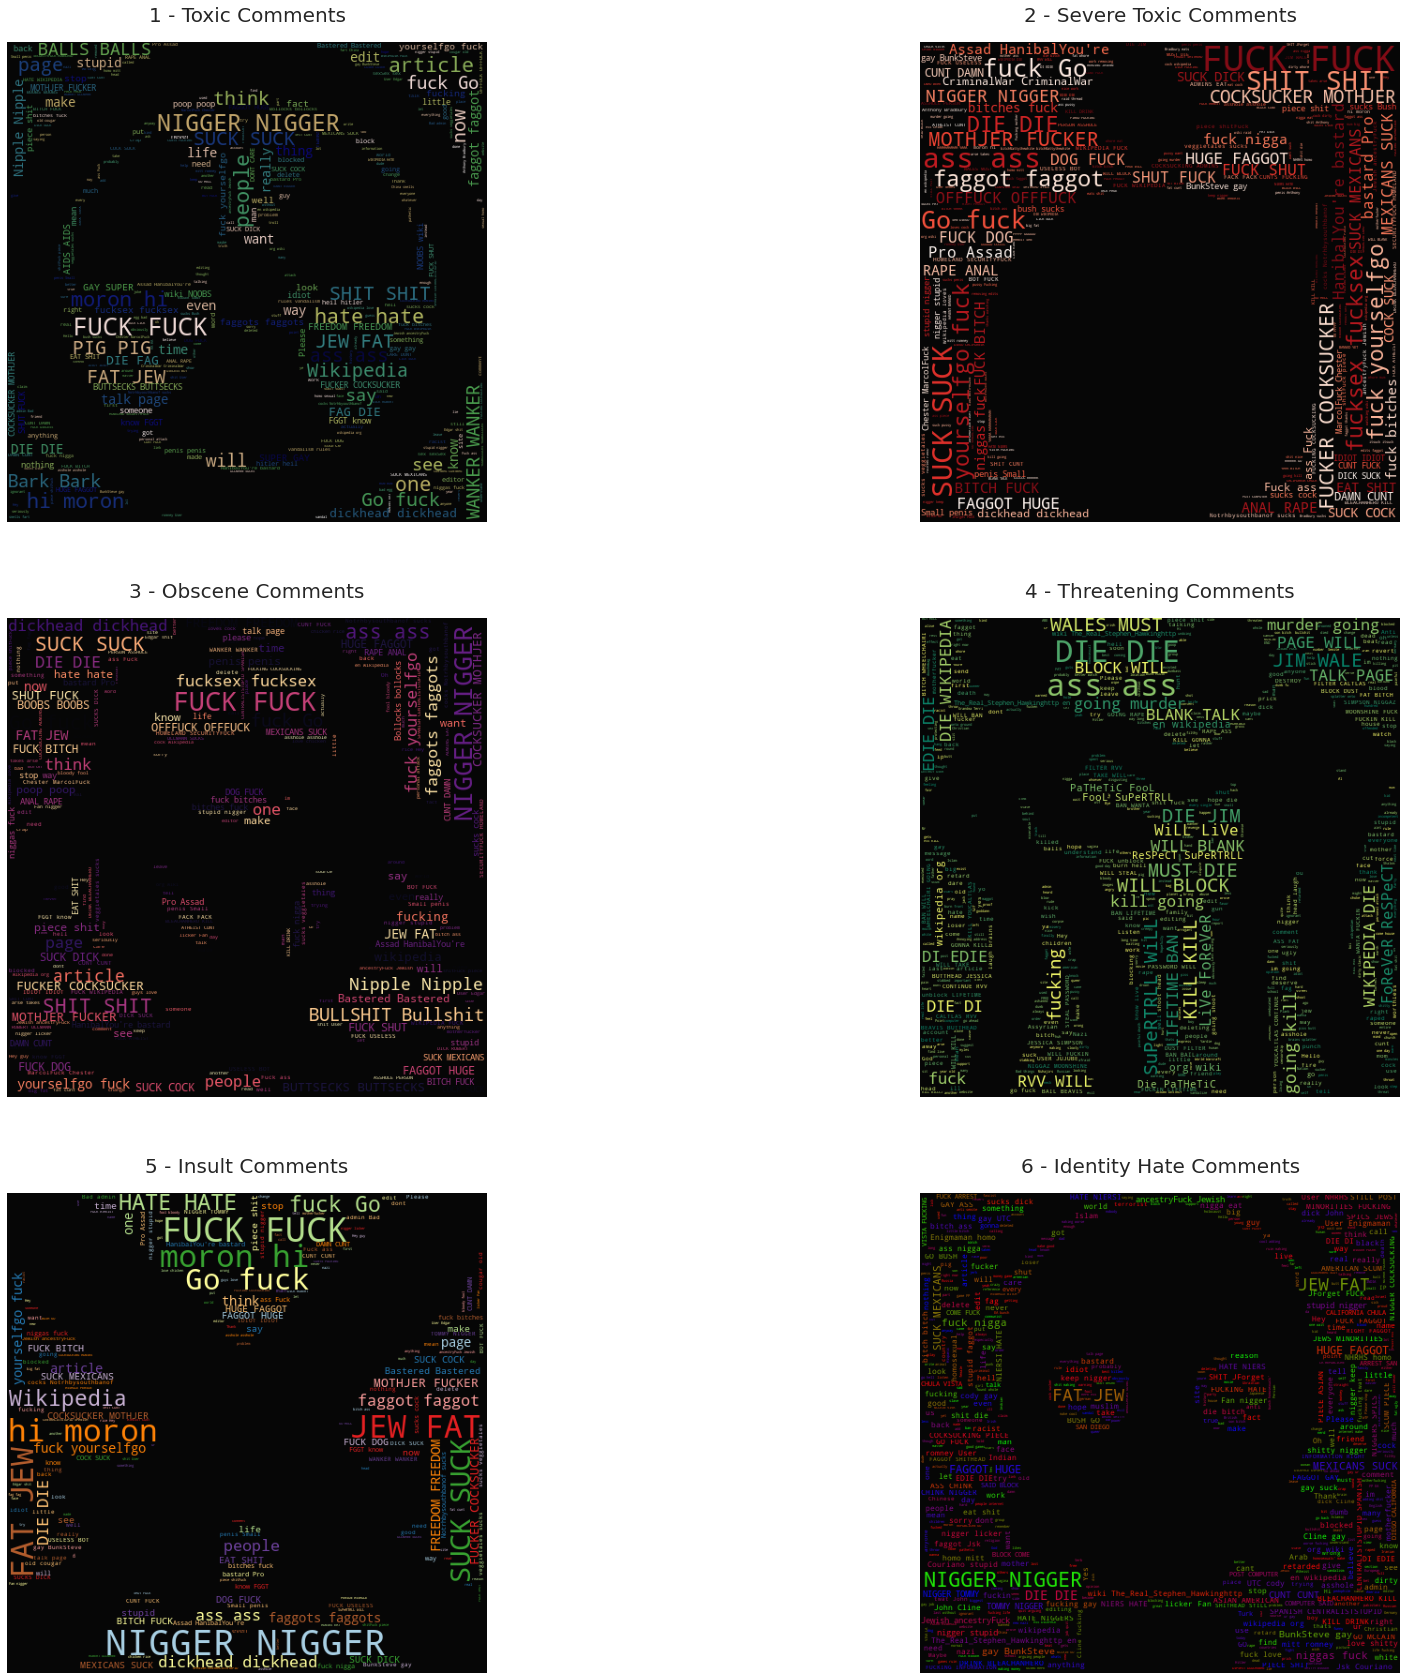

In [30]:
# 1. wordcloud for toxic comments
toxic_mask=np.array(Image.open("/content/drive/MyDrive/Data mining and Text Analytics/group work/picture/1toxic-sign.png"))
toxic_mask=toxic_mask[:,:,1]

text1=commonWord1
wc= WordCloud(background_color="black",max_words=4000,mask=toxic_mask,stopwords=STOPWORDS)
wc.generate(text1)
plt.figure(figsize=(30,30))
plt.subplot(321)
plt.axis("off")
plt.title("1 - Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

# 2. wordcloud for severely toxic comments
plt.subplot(322)
severe_toxic_mask=np.array(Image.open("/content/drive/MyDrive/Data mining and Text Analytics/group work/picture/2bomb.png"))
severe_toxic_mask=severe_toxic_mask[:,:,1]

text2=commonWord2
wc= WordCloud(background_color="black",max_words=2000,mask=severe_toxic_mask,stopwords=STOPWORDS)
wc.generate(text2)
plt.axis("off")
plt.title("2 - Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

# 3. wordcloud for obscene comments
plt.subplot(323)
threat_mask=np.array(Image.open("/content/drive/MyDrive/Data mining and Text Analytics/group work/picture/3biohazard-symbol.png"))
threat_mask=threat_mask[:,:,1]

text3=commonWord3
wc= WordCloud(background_color="black",max_words=2000,mask=threat_mask,stopwords=STOPWORDS)
wc.generate(text3)
plt.axis("off")
plt.title("3 - Obscene Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'magma' , random_state=2534), alpha=0.98)

# 4. wordcloud for threat comments
plt.subplot(324)
threat_mask=np.array(Image.open("/content/drive/MyDrive/Data mining and Text Analytics/group work/picture/4anger.png"))
threat_mask=threat_mask[:,:,1]

text4=commonWord4
wc= WordCloud(background_color="black",max_words=2000,mask=threat_mask,stopwords=STOPWORDS)
wc.generate(text4)
plt.axis("off")
plt.title("4 - Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

# 5. wordcloud for insult comments 
plt.subplot(325)
insult_mask=np.array(Image.open("/content/drive/MyDrive/Data mining and Text Analytics/group work/picture/5swords.png"))
insult_mask=insult_mask[:,:,1]

text5=commonWord5
wc= WordCloud(background_color="black",max_words=2000,mask=insult_mask,stopwords=STOPWORDS)
wc.generate(text5)
plt.axis("off")
plt.title("5 - Insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

# 6. wordcloud for Identity Hate comments 
plt.subplot(326)
insult_mask=np.array(Image.open("/content/drive/MyDrive/Data mining and Text Analytics/group work/picture/6gas-mask.png"))
insult_mask=insult_mask[:,:,1]

text6=commonWord6
wc= WordCloud(background_color="black",max_words=2000,mask=insult_mask,stopwords=STOPWORDS)
wc.generate(text6)
plt.axis("off")
plt.title("6 - Identity Hate Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'brg' , random_state=244), alpha=0.98)

plt.show()

## 4.Creating DataLoader

### 4.1、a little test

![pictre](https://drive.google.com/uc?id=1W7GfFvRTpXEcjrLoR52XAtd7Wj41byyb)

In [31]:
# from pytorch_pretrained_bert import BertTokenizer
from transformers import BertTokenizer
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [32]:
sentence1 = r"Hello, y'all! How are you 😁 ?"
sentence2 = r"'hehidden likes to play'"
tokens = tokenizer(sentence1,sentence2)
print(tokens)
decoded = tokenizer.decode(tokens['input_ids'])
print(decoded)

{'input_ids': [101, 7592, 1010, 1061, 1005, 2035, 999, 2129, 2024, 2017, 100, 1029, 102, 1005, 2002, 27511, 4181, 7777, 2000, 2377, 1005, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
[CLS] hello, y'all! how are you [UNK]? [SEP]'hehidden likes to play'[SEP]


[how to use the function of "tokenizer.encode_plus" ?](https://huggingface.co/docs/transformers/main/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.encode_plus)

[document](https://huggingface.co/transformers/v2.11.0/main_classes/tokenizer.html)

In [33]:
max_token_len_test = 30
tokens = tokenizer.encode_plus(
                 sentence1,sentence2,
                 add_special_tokens=True, # [CLS] & [SEP]
                 max_length=max_token_len_test,
                 return_token_type_ids=True, # token_type_ids: show different segments which are diff sentence
                 padding = 'max_length',
                 truncation = True,
                 return_attention_mask=True, # attention_mask
                 return_tensors='pt'
                 )
print(tokens)

{'input_ids': tensor([[  101,  7592,  1010,  1061,  1005,  2035,   999,  2129,  2024,  2017,
           100,  1029,   102,  1005,  2002, 27511,  4181,  7777,  2000,  2377,
          1005,   102,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0]])}


[how to decode the token ids?](https://huggingface.co/docs/transformers/main/en/glossary#attention-mask)

In [34]:
# must input 1D
decoded = tokenizer.decode(tokens['input_ids'].reshape(-1))
decoded

"[CLS] hello, y'all! how are you [UNK]? [SEP]'hehidden likes to play'[SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

### 4.2、main content

In [35]:
# getting labels
cols_target = df_train.columns[2:].tolist()
cols_target

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

#### 4.2.1、CustomDataset Dataset Class

CustomDataset Dataset Class
- This class is defined to accept the tokenizer, dataframe and max_length as input and generate tokenized output and tags that is used by the BERT model for training.
- We are using the BERT tokenizer to tokenize the data in the comment_text column of the dataframe.
- The tokenizer uses the encode_plus method to perform tokenization and generate the necessary outputs, namely: ids, attention_mask, token_type_ids

In [36]:
from torch.utils.data import DataLoader,Dataset

class ToxicCommentsDataset(Dataset):
    def __init__(self,data:pd.DataFrame, tokenizer:BertTokenizer, max_token_len:int=128, test = False):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.test= test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx:int):

        # extract a row
        data_row = self.data.iloc[idx]
        _id = data_row['id']
        # extract comments
        comment_text = data_row.comment_text

        if not self.test:
          # extract Labels
          labels = data_row[cols_target]

        # encoding word into number
        encoding = self.tokenizer.encode_plus(
                 comment_text,
                 add_special_tokens=True, # [CLS] & [SEP]
                 max_length=self.max_token_len,
                 return_token_type_ids=False,
                 padding = 'max_length',
                 truncation = True,
                 return_attention_mask=True, # attention_mask
                 return_tensors='pt'
                 )
        # to judge different dataset, 
        # train and validation dataset have labels, but test dataset has not labels
        if not self.test:
          return dict( 
              input_ids = torch.tensor(encoding['input_ids'].flatten(), dtype=torch.long),
              attention_mask = torch.tensor(encoding['attention_mask'].flatten(), dtype=torch.long),
              labels = torch.FloatTensor(labels)
              )
        else:
          return dict( 
              input_ids = torch.tensor(encoding['input_ids'].flatten(), dtype=torch.long),
              attention_mask = torch.tensor(encoding['attention_mask'].flatten(), dtype=torch.long),
              )

#### 4.2.2、Create train, val, test dataset

In [225]:
train_df, val_df = train_test_split(df_train, test_size=0.05)

In [226]:
# test=False
MAX_TOKEN_COUNT = 128

train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

val_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

test_dataset = ToxicCommentsDataset(
  df_test,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT,
  test=True
)

#### 4.2.3、Sample dataset ( Train, Val, Test)

train_dataset sample

In [39]:
sample_item = train_dataset[0]
print(sample_item.keys())
print(sample_item["input_ids"])
print(sample_item["attention_mask"])
print(sample_item["labels"])

dict_keys(['input_ids', 'attention_mask', 'labels'])
tensor([  101,  1000,  2478,  3720,  7566, 15327,  2004,  1037,  7057,  4931,
         2045,  1012,  3504,  2066,  2017,  1005,  2128,  2019,  2511,  3559,
         2040,  4282,  1996, 14607,  1025,  2017,  2113,  2488,  2084,  2000,
         2079,  2023,  1012,  4464,  1000,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


val_dataset sample

In [40]:
sample_item = val_dataset[0]
print(sample_item.keys())
print(sample_item["input_ids"])
print(sample_item["attention_mask"])
print(sample_item["labels"])

dict_keys(['input_ids', 'attention_mask', 'labels'])
tensor([  101,  1045,  2017,  9975,  2025, 16755,  2425,  2182,  1010,  2065,
         2009,  2115,  6302,  1006,  2009,  2017,  2064,  2131,  2000,  2502,
         3471,  1007,  1010,  2021,  2017,  2064,  2009,  3066,  2007,  2023,
         4037,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


test_dataset sample (no labels)

In [41]:
sample_item = test_dataset[0]
print(sample_item.keys())
print(sample_item["input_ids"])
print(sample_item["attention_mask"])
# print(sample_item["labels"])

dict_keys(['input_ids', 'attention_mask'])
tensor([  101, 10930,  7743, 14855,  3627,  2003,  2062, 10514,  9468,  2229,
         3993,  2059,  2017,  1005,  2222,  2412,  2022,  2054,  2015,  2039,
         2007,  2017,  1998, 22650,  2017,  6517,  9587, 11263,  3600,  3022,
         1012,  1012,  1012,  1045,  2323,  7743, 14308, 24471,  9004,  9072,
         2594,  2317,  5344,  1998,  2131,  2017,  2000,  3610,  2026,  4632,
         2017,  4364,  5305,  2368,  2033,  1012, 14855,  3627,  2003,  2055,
         6620,  1999,  4830,  2189,  2158,  1012,  2123,  2102,  4487,  4757,
         2008,  4485,  2006,  2032,  1012,  1998, 24218,  2003,  3308, 21388,
         2078,  2066, 10722, 19498,  2002,  2001,  1037,  2567,  2205,  1012,
         1012,  1012,  6616,  2378,  2317,  3337,  2131,  2477,  2157,  2279,
         2051,  1012,  1010,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


#### 4.3.4、Create dataloader

In [227]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

clear memory, to decreass memory occupation

In [107]:
import gc
gc.collect()

13428

## 5.Loading pre trained BERT and setting fine-tuning parameters

[The structure of BertForSequenceClassification](https://zhuanlan.zhihu.com/p/391824482)

In [44]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels = 6)
        
    
    def forward(self, input_ids, mask):
        output= self.l1(input_ids = input_ids, attention_mask = mask )
        return output

model = BERTClass()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BERTClass(
  (l1): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
    

In [45]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {     # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
        'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01
    },
    {   # Filter for parameters which *do* include those.
        'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0
    }
]

# what's the warmup? - Chinese: https://blog.csdn.net/zkq_1986/article/details/100220425
lr = 2e-5
weight_decay=0.01
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr = lr)

In [46]:
#Empty the GPU memory as it might be memory and CPU intensive while training
torch.cuda.empty_cache()
#Number of times the whole dataset will run through the network and model is fine-tuned
epochs = 2
#Iterate over number of epochs
for _ in trange(epochs, desc = "Epoch"):
    #Switch model to train phase where it will update gradients
    model.train()
    #Initaite train and validation loss, number of rows passed and number of batches passed
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    val_loss = 0
    nb_val_examples, nb_val_steps = 0, 0
    #Iterate over batches within the same epoch
    for batch in tqdm(train_dataloader):
        #Shift the batch to GPU for computation
        # batch = tuple(t.to(device) for t in batch)
        #Load the input ids and masks from the batch
        b_input_ids, b_input_mask, b_labels = batch['input_ids'], batch['attention_mask'], batch['labels']
        #print(b_input_ids, b_input_mask, b_labels)
        b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)
        #Initiate gradients to 0 as they tend to add up
        optimizer.zero_grad()
        #Forward pass the input data
        output = model(b_input_ids, b_input_mask).logits
        #We will be using the Binary Cross entropy loss with added sigmoid function after that in BCEWithLogitsLoss
        loss_func = BCEWithLogitsLoss()
        #Calculate the loss between multilabel predicted outputs and actuals
        loss = loss_func(output, b_labels.type_as(output))
        #Backpropogate the loss and calculate the gradients
        loss.backward()
        #Update the weights with the calculated gradients
        optimizer.step()
        #Add the loss of the batch to the final loss, number of rows and batches
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    #Print the current training loss 
    print("Train Loss: {}".format(tr_loss/nb_tr_examples))
    #Switch the model to evaluate stage at which the gradients wont be updated
    model.eval()
    #Iterate over the validation data
    for step, batch in enumerate(val_dataloader):
        #Shift the validation data to GPUs for computation
        # batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch['input_ids'], batch['attention_mask'], batch['labels']
        #We dont want to update the gradients
        with torch.no_grad():
            #Load the input ids and masks from the batch
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)
            #Forward pass the input data
            output = model(b_input_ids, b_input_mask).logits
            #We will be using the Binary Cross entropy loss with added sigmoid function after that in BCEWithLogitsLoss
            loss_func = BCEWithLogitsLoss()
            #Calculate the loss between multilabel predicted outputs and actuals
            loss = loss_func(output, b_labels.type_as(output))
            #Add the loss of the batch to the final loss, number of rows and batches
            val_loss += loss.item()
            nb_val_examples += b_input_ids.size(0)
            nb_val_steps += 1
    #Print the current validation loss     
    print("Valid Loss: {}".format(val_loss/nb_val_examples))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4738 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train Loss: 0.0015606572380703681
Valid Loss: 0.0013005952306441018


  0%|          | 0/4738 [00:00<?, ?it/s]

Train Loss: 0.0010533592161513755
Valid Loss: 0.0011891231011705345


In [47]:
ROOT = '/content/drive/MyDrive/Data mining and Text Analytics/group work/save_model/'
results_path = ROOT+'CommentClassifier.pt'
torch.save({"state_dict": model.state_dict()}, results_path)

## 6.Predicting and Submitting for Test Data

In [48]:
results_path = ROOT+'CommentClassifier.pt'
data = torch.load(results_path)
model.load_state_dict(data["state_dict"])

<All keys matched successfully>

In [228]:
outputs = []

#Iterate over the test_loader 
for step, batch in enumerate(test_dataloader):
        #Transfer batch to GPUs
        # batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask = batch['input_ids'], batch['attention_mask']
        #We dont need to update gradients as we are just predicting
        with torch.no_grad():
            #Bring up the next batch of input_texts and attention_masks 
            # b_input_ids, b_input_mask = batch
            #print(b_input_ids, b_input_mask, b_labels)
            b_input_ids, b_input_mask = b_input_ids.to(device), b_input_mask.to(device)
            #Forward propogate the inputs and get output as logits
            output = model(b_input_ids, b_input_mask)
            #Pass the outputs through a sigmoid function to get the multi-label preditions
            s = Sigmoid()
            out = s(output.logits).to('cpu').numpy()    
            #Add the predictions for this batch to the final list
            outputs.extend(out)
            
#Merge test df and submission table to have all columns in a table
df_test = pd.merge(df_test, sample_submission, on = "id")
#Assign the predictions to the toxic_output columns
df_test[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]] = outputs
#Drop text data as it is not expected in the submission file
df_test.drop(["comment_text"], axis = 1, inplace = True)
#Saving the submission dataframe
df_test.to_csv("/content/drive/MyDrive/Data mining and Text Analytics/group work/result/Reddit_sub.csv", index = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [229]:
reddit_result = pd.read_csv('/content/drive/MyDrive/Data mining and Text Analytics/group work/result/Reddit_sub.csv')
reddit_result

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,NaN,0.000566,0.000113,0.000274,0.000095,0.000266,0.000115
1,NaN,0.000528,0.000130,0.000340,0.000099,0.000274,0.000143
2,NaN,0.028850,0.000162,0.003856,0.000124,0.001219,0.000173
3,NaN,0.933582,0.016620,0.880896,0.001249,0.065262,0.000979
4,NaN,0.001413,0.000103,0.000436,0.000085,0.000350,0.000097
...,...,...,...,...,...,...,...
14286,NaN,0.978658,0.041521,0.492623,0.006127,0.734607,0.512268
14287,NaN,0.989391,0.112559,0.800392,0.009466,0.883320,0.614434
14288,NaN,0.995369,0.533666,0.937548,0.692923,0.922220,0.619055
14289,NaN,0.997356,0.351445,0.979620,0.013103,0.958710,0.263835


In [230]:
reddit_result1 = reddit_result.where(reddit_result>0.5,0)
reddit_result2 = reddit_result1.where(reddit_result1<0.5,1)

In [231]:
reddit_result2.drop('id',inplace=True,axis=1)

In [232]:
reddit_result2

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
14286,1.0,0.0,0.0,0.0,1.0,1.0
14287,1.0,0.0,1.0,0.0,1.0,1.0
14288,1.0,1.0,1.0,1.0,1.0,1.0
14289,1.0,0.0,1.0,0.0,1.0,0.0


In [233]:
comments = pd.read_csv('/content/drive/MyDrive/Data mining and Text Analytics/group work/jigsaw-toxic-comment-classification-challenge/Reddit_final.csv')
comments.shape

(14291, 2)

In [234]:
final_data = pd.concat([reddit_result2, comments],axis=1)

In [235]:
final_data

,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text,id
0,0.0,0.0,0.0,0.0,0.0,0.0,serious suggestions only 😆,u9cg12
1,0.0,0.0,0.0,0.0,0.0,0.0,cool recovery at practice 1,u9di1r
2,0.0,0.0,0.0,0.0,0.0,0.0,Which song's lyrics sounds innocent but actual...,u8ybww
3,1.0,0.0,1.0,0.0,0.0,0.0,Boomer owner send this out last night before l...,u9eh2r
4,0.0,0.0,0.0,0.0,0.0,0.0,This sign at an Illinois rest stop encouraging...,u93285
...,...,...,...,...,...,...,...,...
14286,1.0,0.0,0.0,0.0,1.0,1.0,Gay \n\nThe existence of CDVF is further proof...,01166f26ee280e56
14287,1.0,0.0,1.0,0.0,1.0,1.0,Dictionaries\n\nHow dare you call my contribut...,015d1b0bb4cc744d
14288,1.0,1.0,1.0,1.0,1.0,1.0,"you gay motherfucker i know where you live,i a...",026bd33490542b2e
14289,1.0,0.0,1.0,0.0,1.0,0.0,you studid cock sucker u stop callin me ok its...,029dceed3519e371


In [236]:
clean_comment1 = final_data[(df_train['toxic']!=1) & (final_data['severe_toxic']!=1) & (final_data['obscene']!=1) & (final_data['threat']!=1) & (final_data['insult']!=1) & (final_data['identity_hate']!=1)]['comment_text']

toxic1 = final_data[(final_data['toxic']==1)]['comment_text']
severe_toxic1 = final_data[(final_data['severe_toxic']==1)]['comment_text']
obscene1 = final_data[(final_data['obscene']==1)]['comment_text']
threat1 = final_data[(final_data['threat']==1)]['comment_text']
insult1 = final_data[(final_data['insult']==1)]['comment_text']
identity_hate1 = final_data[(final_data['identity_hate']==1)]['comment_text']

print('the number of each type of comment: ')
print('clean comment: ',len(clean_comment1))

print('toxic comment: ',len(toxic1))
print('severe toxic comment: ',len(severe_toxic1))
print('obscene comment: ',len(obscene1))
print('threat comment: ',len(threat1))
print('insult comment: ',len(insult1))
print('identity hate comment: ',len(identity_hate1))

the number of each type of comment: 
clean comment:  12490
toxic comment:  869
severe toxic comment:  19
obscene comment:  446
threat comment:  31
insult comment:  287
identity hate comment:  11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


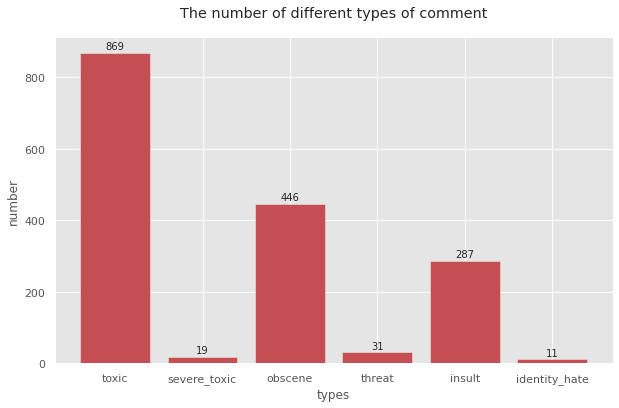

In [237]:
# using different style to draw table
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
left = range(len(cols_target))
value_list1 = [len(toxic1), len(severe_toxic1), len(obscene1), len(threat1), len(insult1), len(identity_hate1)]
tick_label1 = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
plt.bar(x=left, height=value_list1, tick_label=tick_label1, color='r')
plt.title('The number of different types of comment')
plt.ylabel('number')
plt.xlabel('types')

for x, y in enumerate(value_list1):
  plt.text(x, y+10, '%s'%round(y,1), ha='center')
plt.show()

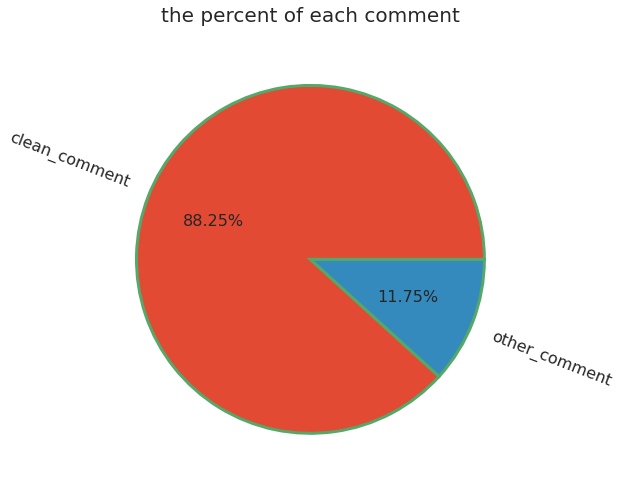

In [238]:
value_list = [len(clean_comment1), len(toxic1)+len(severe_toxic1)+len(obscene1)+len(threat1)+len(insult1)+len(identity_hate1)]
tick_label = ['clean_comment', 'other_comment']

names = tick_label
percents = value_list
plt.figure(figsize=(12,8))
plt.title('the percent of each comment', fontsize=20)
patches,texts,autotexts = plt.pie(percents, labels=names, autopct="%.2f%%", textprops={'fontsize':16}, wedgeprops = {'linewidth': 3, 'edgecolor':'g'}, center=(0.2,0.2), rotatelabels=True)

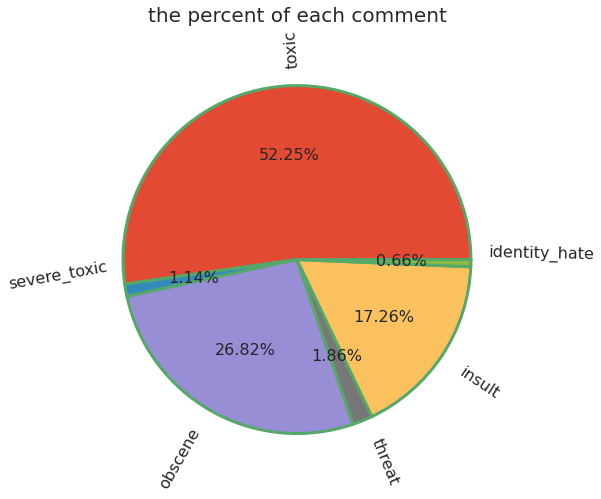

In [239]:
value_list = [len(toxic1), len(severe_toxic1), len(obscene1), len(threat1), len(insult1), len(identity_hate1)]
tick_label = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

names = tick_label
percents = value_list
plt.figure(figsize=(12,8))
plt.title('the percent of each comment', fontsize=20)
patches,texts,autotexts = plt.pie(percents, labels=names, autopct="%.2f%%", textprops={'fontsize':16}, wedgeprops = {'linewidth': 3, 'edgecolor':'g'}, center=(0.2,0.2), rotatelabels=True)